**semantic scolar**

by design semanti scholar academic graph API's paper search endpoints only match your query against the title and abstact of each paper .

In [1]:
import requests
import pandas as pd
import time

# Basic search parameters
url = "https://api.semanticscholar.org/graph/v1/paper/search/bulk"
params = {
    'query': 'quantum tunneling',
    'fields': 'title,authors,venue,publicationVenue,year,publicationDate,citationCount,abstract,influentialCitationCount,fieldsOfStudy,publicationTypes',
    'limit': 500
}

# Optional: Include your API key if you have one
# headers = {
#     'x-api-key': 'YOUR_API_KEY'
# }

max_retries = 5  # Maximum number of retries
retry_delay = 60  # Delay in seconds before retrying

for attempt in range(max_retries):
    response = requests.get(url, params=params)  # Add headers=headers if using an API key
    if response.status_code == 200:
        data = response.json()
        print(data)
        break  # Exit the loop if the request was successful
    elif response.status_code == 429:
        print(f"Too many requests. Waiting for {retry_delay} seconds before retrying...")
        time.sleep(retry_delay)  # Wait before retrying
    else:
        print(f"Request failed with status code: {response.status_code}")
        break  # Exit the loop on other errors

# If you want to process the data further, you can do so here

{'total': 44089, 'token': 'PCOKWVSKJJGM4TWNJNI3EUSQJIWVNUSRKBFEYK2JFUBHFI4VBRGBGLMTBQWUYDGMCJJ43UUSBSGVHTEMJUGIYDOSZQW43DMSKJJVHDJNSNJCYTEMSRRGWAPN4YKDG', 'data': [{'paperId': '000025e4a4d3d6e1ed39c79baef6fcdb82531b7a', 'publicationVenue': {'id': 'ca1505a3-13c6-43fa-9997-7ad050b7de33', 'name': 'Physical Review D, Particles and fields', 'alternate_names': ['Phys Rev D Part field', 'Phys Rev D', 'Physical Review D'], 'issn': '0556-2821', 'alternate_issns': ['1550-2368', '1089-4918', '1550-7998'], 'url': 'https://journals.aps.org/prd/', 'alternate_urls': ['http://prd.aps.org/']}, 'title': 'Classical and quantum cosmology of the Starobinsky inflationary model.', 'abstract': None, 'venue': 'Physical Review D, Particles and fields', 'year': 1985, 'citationCount': 321, 'influentialCitationCount': 13, 'openAccessPdf': {'url': '', 'status': 'CLOSED', 'license': None, 'disclaimer': "Notice: This paper's abstract has been elided by the publisher. Paper or abstract available at https://api.unpaywa

In [2]:
import requests
import pandas as pd
import re

# Debug print to check keys for the first paper
if data.get('data'):
    print("Available keys in first paper:", data['data'][0].keys())

papers = data.get('data', [])
rows = []
for paper in papers:
    # Safely handle the possibility of publicationVenue being None
    pub_venue = paper.get('publicationVenue') or {}
    pub_venue_name = pub_venue.get('name') if isinstance(pub_venue, dict) else paper.get('venue')
    pub_venue_type = pub_venue.get('type') if isinstance(pub_venue, dict) else 'unknown'
    issn = pub_venue.get('issn') if isinstance(pub_venue, dict) else None

    # Get publication date with a fallback value (if missing, use 'Unknown')
    pub_date = paper.get('publicationDate', 'Unknown')

    # Extract author names
    authors = paper.get('authors', [])
    author_names = [author.get('name', '') for author in authors]

    # Extract DOI from the openAccessPdf disclaimer if present
    doi = None
    disclaimer = paper.get('openAccessPdf', {}).get('disclaimer', '')
    doi_match = re.search(r'https?://doi\.org/([^\s]+)', disclaimer)
    if doi_match:
        doi = doi_match.group(1).rstrip('.')

    # Build row dictionary
    row = {
        'Title': paper.get('title', ''),
        'Abstract': paper.get('abstract', ''),
        'PublicationVenueName': pub_venue_name or paper.get('venue'),
        'PublicationVenueType': pub_venue_type,
        'Year': paper.get('year', None),
        'ReferenceCount': paper.get('referenceCount', None),
        'CitationCount': paper.get('citationCount', None),
        'InfluentialCitationCount': paper.get('influentialCitationCount', None),
        'FieldsOfStudy': paper.get('fieldsOfStudy', []),
        'PublicationTypes': paper.get('publicationTypes', []),
        'PublicationDate': pub_date,
        'Authors': ', '.join(author_names) if author_names else None,
        'DOI': doi,
        'ISSN': issn
    }
    rows.append(row)

# Create DataFrame and display the first few rows
sem_df = pd.DataFrame(rows)
sem_df.head(2)


Available keys in first paper: dict_keys(['paperId', 'publicationVenue', 'title', 'abstract', 'venue', 'year', 'citationCount', 'influentialCitationCount', 'openAccessPdf', 'fieldsOfStudy', 'publicationTypes', 'publicationDate', 'authors'])


,Title,Abstract,PublicationVenueName,PublicationVenueType,Year,ReferenceCount,CitationCount,InfluentialCitationCount,FieldsOfStudy,PublicationTypes,PublicationDate,Authors,DOI,ISSN
0,Classical and quantum cosmology of the Starobi...,None,"Physical Review D, Particles and fields",None,1985.0,None,321,13,"[Physics, Medicine]","[JournalArticle, Review]",1985-11-15,A. Vilenkin,"10.1103/PHYSREVD.32.2511,",0556-2821
1,Reduced dimensionality quantum dynamics of CH3...,None,Journal of Physical Chemistry A,journal,2009.0,None,25,1,"[Chemistry, Medicine]",[JournalArticle],2009-04-23,"S. Remmert, S. T. Banks, D. Clary","10.1021/jp810803k,",1089-5639


In [3]:
len(sem_df), sem_df.columns

(1000,
 Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
        'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
        'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
        'DOI', 'ISSN'],
       dtype='object'))

In [4]:
# 1) Force everything to string, strip, then measure length
lengths = sem_df['PublicationVenueName'] \
    .astype(str) \
    .str.strip() \
    .str.len()

# 2) How many have length == 0?
n_blank = (lengths == 0).sum()
print(f"Number of truly blank venue names: {n_blank}")

# 3) (Optional) inspect a few reprs to understand what's in there
print(sem_df['PublicationVenueName']
      .head(10)
      .apply(lambda x: repr(x)))


Number of truly blank venue names: 631
0    'Physical Review D, Particles and fields'
1            'Journal of Physical Chemistry A'
2                                           ''
3                           'Nature Materials'
4                                           ''
5                                           ''
6                                           ''
7                                           ''
8                                           ''
9                                           ''
Name: PublicationVenueName, dtype: object


In [5]:
sem_df.isna().sum()

Title                          0
Abstract                     879
PublicationVenueName           0
PublicationVenueType         731
Year                          14
ReferenceCount              1000
CitationCount                  0
InfluentialCitationCount       0
FieldsOfStudy                110
PublicationTypes             702
PublicationDate              192
Authors                       10
DOI                          437
ISSN                         734
dtype: int64

In [6]:
sem_df['year'] = pd.to_datetime(sem_df['PublicationDate'], errors='coerce').dt.year
    
    # Convert to integer (NaN becomes <NA> which is better for visualization)
sem_df['year'] = sem_df['year'].astype('Int64')

In [7]:
sem_df = sem_df[~((sem_df['PublicationVenueName'] == '') | (sem_df['year'].isnull()))]


In [8]:
len(sem_df)

352

In [9]:
sem_df.columns

Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
       'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'DOI', 'ISSN', 'year'],
      dtype='object')

Text(0.5, 1.0, 'Publications per Year')

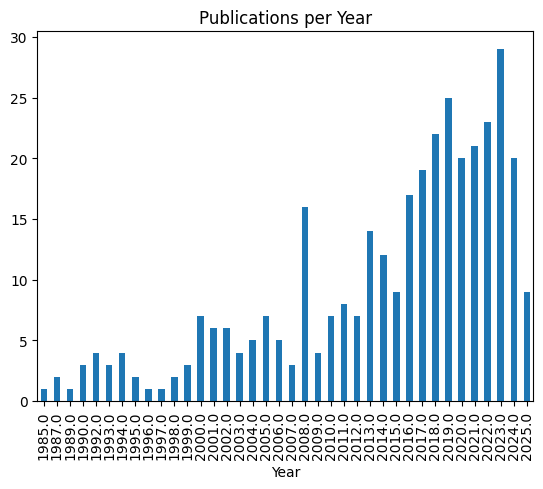

In [10]:
import matplotlib.pyplot as plt
sem_df['Year'].value_counts().sort_index().plot(kind='bar')
plt.title("Publications per Year")

In [11]:
# import pandas as pd

# # Load the Impact Factor dataset
# if_data = pd.read_excel("CopyofImpactFactor2024.xlsx", sheet_name="2024最新完整版IF")

# # Clean journal names and create a combined ISSN column
# if_data["CleanName"] = (
#     if_data["Name"]
#     .str.lower()
#     .str.replace(r"[^a-z0-9 ]", "", regex=True)  # Remove special characters
#     .str.strip()  # Remove leading/trailing spaces
# )
# if_data["ISSN_Combined"] = (
#     if_data["ISSN"].fillna("") + "," + if_data["EISSN"].fillna("")
# )

In [12]:
sem_df.columns

Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
       'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'DOI', 'ISSN', 'year'],
      dtype='object')

In [13]:
len(sem_df)

352

In [14]:
sem_df['FieldsOfStudy'].iloc[0]

['Physics', 'Medicine']

In [15]:
sem_df['PublicationVenueName'].iloc[77]

'Journal of Physical Chemistry A'

In [16]:
# Top 10 influential papers
sem_df.sort_values('InfluentialCitationCount', ascending=False).head()

,Title,Abstract,PublicationVenueName,PublicationVenueType,Year,ReferenceCount,CitationCount,InfluentialCitationCount,FieldsOfStudy,PublicationTypes,PublicationDate,Authors,DOI,ISSN,year
0,Classical and quantum cosmology of the Starobi...,None,"Physical Review D, Particles and fields",None,1985.0,None,321,13,"[Physics, Medicine]","[JournalArticle, Review]",1985-11-15,A. Vilenkin,"10.1103/PHYSREVD.32.2511,",0556-2821,1985
361,A generalized non-local optical response theor...,None,Nature Communications,journal,2013.0,None,469,12,"[Physics, Medicine]",[JournalArticle],2013-12-27,"N. Mortensen, S. Raza, M. Wubs, T. Søndergaard...",None,2041-1723,2013
504,The formation of highly oxidized multifunction...,The prompt formation of highly oxidized organi...,Journal of the American Chemical Society,journal,2014.0,None,273,10,"[Chemistry, Medicine]",[JournalArticle],2014-10-21,"M. Rissanen, T. Kurtén, M. Sipilä, J. Thornton...","10.1021/ja507146s,",0002-7863,2014
780,Dynamical control of matter-wave tunneling in ...,None,Physical Review Letters,journal,2007.0,None,445,10,"[Medicine, Physics]",[JournalArticle],2007-07-03,"H. Lignier, C. Sias, D. Ciampini, Y. Singh, A....",None,0031-9007,2007
722,Effect of the electromagnetic environment on t...,None,Physical Review Letters,journal,1990.0,None,347,9,"[Physics, Medicine]",[JournalArticle],1990-04-09,"M. Devoret, D. Estève, H. Grabert, G. Ingold, ...","10.1103/PHYSREVLETT.64.1824,",0031-9007,1990


In [17]:
#sem_df = sem_df[~((sem_df['PublicationVenueName'] == '') | (sem_df['FieldsOfStudy'].isnull()))]
sem_df = sem_df[~((sem_df['PublicationVenueName'] == '') | (sem_df['Year'].isnull()))]
sem_df.reset_index(drop=True, inplace=True)

In [18]:
sem_df['FieldsOfStudy'].explode().unique()

array(['Physics', 'Medicine', 'Chemistry', 'Materials Science', None,
       'Engineering', 'Computer Science', 'Mathematics', 'Biology'],
      dtype=object)

In [19]:
len(sem_df)

352

In [20]:
sem_df.isnull().sum()

Title                         0
Abstract                    275
PublicationVenueName          0
PublicationVenueType         90
Year                          0
ReferenceCount              352
CitationCount                 0
InfluentialCitationCount      0
FieldsOfStudy                46
PublicationTypes             99
PublicationDate               0
Authors                       2
DOI                         124
ISSN                         90
year                          0
dtype: int64

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def plot_field_trends(sem_df, fields_to_plot=None, smoothing_window=3, figsize=(12, 6)):
    """
    Plot trends of specified fields of study over time, or top growing fields if none specified.
    
    Parameters:
    - sem_df: Input DataFrame containing 'Year' and 'FieldsOfStudy' columns
    - fields_to_plot: List of specific fields to plot (if None, plots top 5 growing fields)
    - smoothing_window: Number of years for rolling average smoothing
    - figsize: Size of the output figure
    """
    # Explode FieldsOfStudy so each field gets its own row
    df_exploded = sem_df.explode('FieldsOfStudy')
    
    # Group by Year and Field, then count papers
    field_counts = (
        df_exploded
        .groupby(['Year', 'FieldsOfStudy'])
        .size()
        .reset_index(name='PaperCount')
    )
    
    # Pivot for heatmap-style analysis or trend lines
    field_pivot = field_counts.pivot(index='Year', columns='FieldsOfStudy', values='PaperCount').fillna(0)
    
    # Smooth with rolling average
    field_pivot_smooth = field_pivot.rolling(window=smoothing_window, min_periods=1).mean()
    
    # Determine which fields to plot
    if fields_to_plot is None:
        # Calculate top growing fields if none specified
        recent_years = field_pivot_smooth.index[-3:]  # Last 3 years
        growth = field_pivot_smooth.loc[recent_years].pct_change().mean()
        fields_to_plot = growth.sort_values(ascending=False).head(5).index
        plot_title = 'Top 5 Emerging Fields of Study'
    else:
        # Use specified fields, filtering to only those available in data
        available_fields = [f for f in fields_to_plot if f in field_pivot_smooth.columns]
        if not available_fields:
            raise ValueError("None of the specified fields were found in the data")
        fields_to_plot = available_fields
        plot_title = 'Trends for Selected research Fields of Study'
    
    # Plot trends
    plt.figure(figsize=figsize)
    for field in fields_to_plot:
        plt.plot(field_pivot_smooth.index, field_pivot_smooth[field], label=field)
    
    plt.title(plot_title)
    plt.xlabel('Year')
    plt.ylabel(f'Number of Papers (Smoothed, {smoothing_window}-year avg)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# To plot specific fields:
# plot_field_trends(sem_df, fields_to_plot=['Machine Learning', 'Neuroscience', 'Physics'])

# To plot top growing fields:
# plot_field_trends(sem_df)

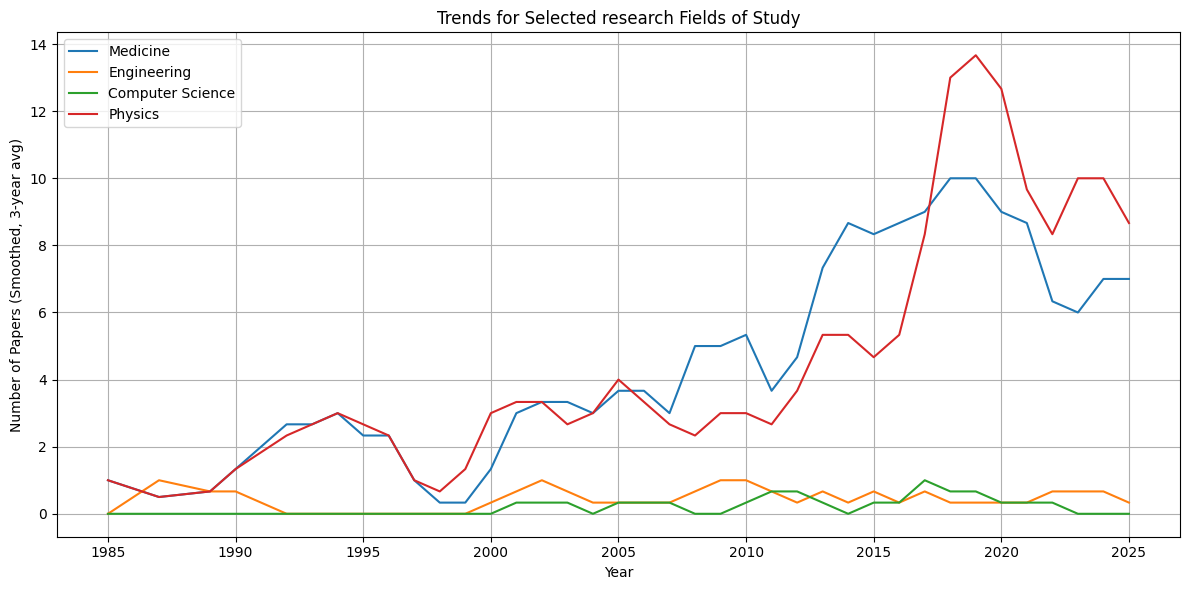

In [24]:
plot_field_trends(sem_df, fields_to_plot=['Medicine', 'Engineering','Computer Science','Physics'])

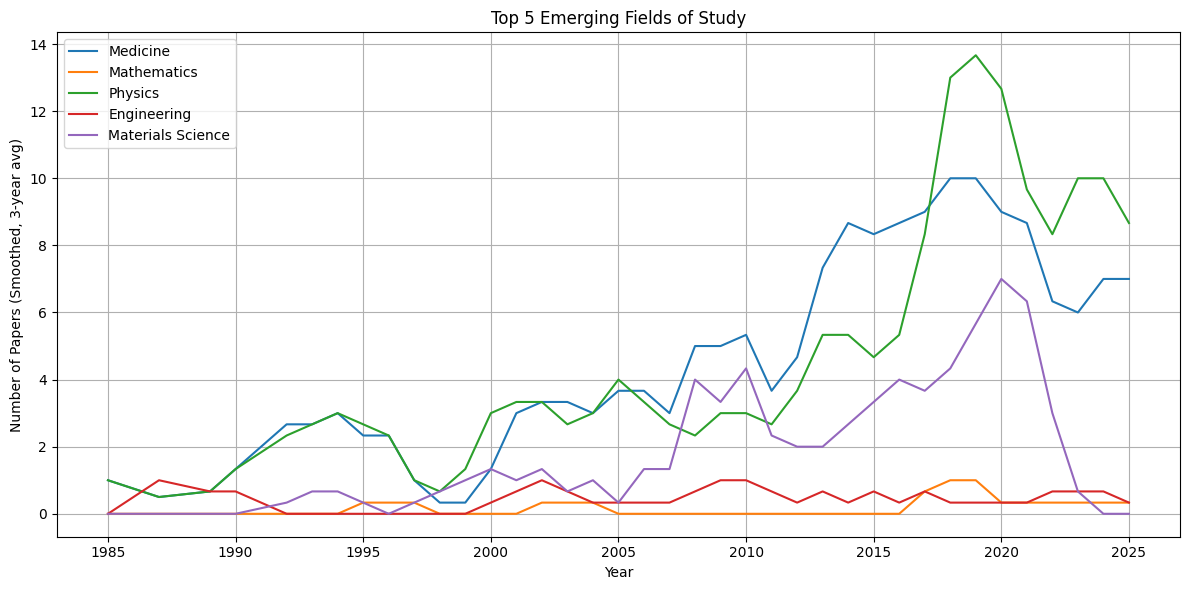

In [25]:
plot_field_trends(sem_df)

In [27]:
fig, trend_data = visualize_filing_trends(sem_df)
fig.show()

**keyword analysis**

In [28]:
keyword_df = sem_df.copy()

In [29]:
keyword_df = keyword_df.dropna(subset=['Title'])

In [30]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

#preprocessing : lowercase and remove puctuation , remove stop words and perform stemming an lemmatization 
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def preprocess_text(text: str,use_stemming: bool = True) -> str:
    # Lowercase and remove punctuation
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    else:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Example usage:
keyword_df['Title'] = keyword_df['Title'].apply(preprocess_text)

keyword_df['Title'].head()


0    classic quantum cosmolog starobinski inflation...
1    reduc dimension quantum dynam ch3 ch4 ch4 ch3 ...
2    imag moiré excit state photocurr tunnel micros...
3    fresh look calcul tunnel action multifield pot...
4    high sn crystallin measur effect defect passiv...
Name: Title, dtype: object

In [35]:
#combine abstracts by year 
grouped = keyword_df.groupby("Year")["Title"].apply(lambda texts: " ".join(texts)).reset_index()


In [36]:
from itertools import combinations
from collections import defaultdict

def build_cooccurrence(text: str, window_size: int = 5) -> dict:
    """
    Build a co-occurrence dictionary using a sliding window.
    
    Each window of 'window_size' tokens yields co-occurring pairs.
    """
    tokens = text.split()
    cooccurrences = defaultdict(int)
    
    # Iterate over all tokens with sliding window
    for i in range(len(tokens)):
        window = tokens[i:i + window_size]
        # Generate all combinations (order doesn't matter) from the current window
        for pair in combinations(window, 2):
            # Sort the pair to keep the ordering consistent (so ('a','b') is the same as ('b','a'))
            cooccurrences[tuple(sorted(pair))] += 1
    
    return cooccurrences

# Example usage:
# Assuming 'grouped' is your DataFrame and it contains a non-empty "abstract" column.
sample_text = grouped.loc[0, "Title"]  # Replace with your actual text if needed.
cooc = build_cooccurrence(sample_text, window_size=5)
print("Co-occurrence dictionary:")
print(dict(cooc))
print("Number of edges (unique pairs):", len(cooc))


Co-occurrence dictionary:
{('classic', 'quantum'): 1, ('classic', 'cosmolog'): 1, ('classic', 'starobinski'): 1, ('classic', 'inflationari'): 1, ('cosmolog', 'quantum'): 2, ('quantum', 'starobinski'): 2, ('inflationari', 'quantum'): 2, ('cosmolog', 'starobinski'): 3, ('cosmolog', 'inflationari'): 3, ('inflationari', 'starobinski'): 4, ('model', 'quantum'): 1, ('cosmolog', 'model'): 2, ('model', 'starobinski'): 3, ('inflationari', 'model'): 4}
Number of edges (unique pairs): 14


In [37]:
from sklearn.cluster import KMeans
import numpy as np
#identify clusters of similar documents based on the terms they contain 
# Suppose we use TF-IDF of a given time window
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Map terms to cluster centers can be done via:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
cluster_terms = {}
for i in range(num_clusters):
    cluster_terms[i] = [feature_names[ind] for ind in order_centroids[i, :10]]
    print("Cluster %d:" % i, cluster_terms[i])


Cluster 0: ['tunnel', 'quantum tunnel', 'quantum', 'reson', 'reson tunnel', 'diod', 'junction', 'via', 'potenti', 'tunnel diod']
Cluster 1: ['quantum', 'quantum dot', 'dot', 'well', 'quantum well', 'doubl quantum', 'system', 'doubl', 'doubl quantum dot', 'effect']
Cluster 2: ['magnet', 'studi', 'singlemolecul', 'singlemolecul magnet', 'complex', 'singleion', 'tunnel', 'zerofield', 'quantum', 'singleion magnet']
Cluster 3: ['atom', 'high', 'transistor', 'charg', 'twodimens', 'dynam', 'state', 'transit', 'phase', 'mechan']
Cluster 4: ['electron', 'gener', 'electron transport', 'twodimens', 'transport', 'electron transfer', 'electron tunnel', 'electron quantum', 'potenti', 'transfer']


In [38]:
import networkx as nx
from networkx.algorithms import community
#identify groups of terms that frequently co-occur 
# Build graph from aggregated co-occurrence (for a single time window)
G = nx.Graph()
for (term1, term2), weight in cooc.items():
    if weight > 1:
        G.add_edge(term1, term2, weight=weight)

# Detect communities using a greedy modularity algorithm
communities = community.greedy_modularity_communities(G)
print("Communities:")
for idx, comm in enumerate(communities, start=1):
    print(f"Cluster {idx}:", sorted(comm))


Communities:
Cluster 1: ['cosmolog', 'inflationari', 'model', 'quantum', 'starobinski']


In [46]:
sem_df.head(1)

,Title,Abstract,PublicationVenueName,PublicationVenueType,Year,ReferenceCount,CitationCount,InfluentialCitationCount,FieldsOfStudy,PublicationTypes,PublicationDate,Authors,DOI,ISSN,year
0,Classical and quantum cosmology of the Starobi...,None,"Physical Review D, Particles and fields",None,1985.0,None,321,13,"[Physics, Medicine]","[JournalArticle, Review]",1985-11-15,A. Vilenkin,"10.1103/PHYSREVD.32.2511,",0556-2821,1985


In [47]:
sem_df.columns

Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
       'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'DOI', 'ISSN', 'year'],
      dtype='object')

**impact factor**

In [48]:
if_data = pd.read_excel("CopyofImpactFactor2024.xlsx", sheet_name="2024最新完整版IF")

In [49]:
if_data.columns

Index(['Name', 'Abbr Name', 'ISSN', 'EISSN', 'JIF', 'JIF5Years', 'Category'], dtype='object')

In [50]:
if_data.head()

,Name,Abbr Name,ISSN,EISSN,JIF,JIF5Years,Category
0,CA-A CANCER JOURNAL FOR CLINICIANS,CA-CANCER J CLIN,0007-9235,1542-4863,503.1,297.0,ONCOLOGY|Q1|1/322
1,NATURE REVIEWS DRUG DISCOVERY,NAT REV DRUG DISCOV,1474-1776,1474-1784,122.7,114.9,PHARMACOLOGY & PHARMACY|Q1|1/354
2,LANCET,LANCET,0140-6736,1474-547X,98.4,106.9,"MEDICINE, GENERAL & INTERNAL|Q1|1/325"
3,NEW ENGLAND JOURNAL OF MEDICINE,NEW ENGL J MED,0028-4793,1533-4406,96.2,94.3,"MEDICINE, GENERAL & INTERNAL|Q1|2/325"
4,BMJ-British Medical Journal,BMJ-BRIT MED J,0959-535X,1756-1833,93.6,69.9,"MEDICINE, GENERAL & INTERNAL|Q1|3/325"


In [51]:
if 'Category' in if_data.columns:
  unique_categories = if_data['Category'].unique()
  print(unique_categories)
else:
  print("The 'Category' column does not exist in the dataset.")

['ONCOLOGY|Q1|1/322' 'PHARMACOLOGY & PHARMACY|Q1|1/354'
 'MEDICINE, GENERAL & INTERNAL|Q1|1/325' ...
 'DEVELOPMENT STUDIES|Q3|39/63' 'GERONTOLOGY|Q3|27/47'
 'PHYSICS, MULTIDISCIPLINARY|Q2|54/110']


In [52]:
# Parse and clean the unique categories
cleaned_categories = set()
for category in unique_categories:
  # Split by '|' and '&', and take the first part
  cleaned = category.split('|')[0].strip()
  cleaned_categories.add(cleaned)

# Convert the set to a sorted list of unique keywords
unique_keywords = sorted(cleaned_categories)
print(unique_keywords)

['ACOUSTICS', 'AGRICULTURAL ECONOMICS & POLICY', 'AGRICULTURAL ENGINEERING', 'AGRICULTURE, DAIRY & ANIMAL SCIENCE', 'AGRICULTURE, MULTIDISCIPLINARY', 'AGRONOMY', 'ALLERGY', 'ANATOMY & MORPHOLOGY', 'ANDROLOGY', 'ANESTHESIOLOGY', 'ANTHROPOLOGY', 'ARCHAEOLOGY', 'ARCHITECTURE', 'AREA STUDIES', 'ART', 'ASIAN STUDIES', 'ASTRONOMY & ASTROPHYSICS', 'AUDIOLOGY & SPEECH-LANGUAGE PATHOLOGY', 'AUTOMATION & CONTROL SYSTEMS', 'BEHAVIORAL SCIENCES', 'BIOCHEMICAL RESEARCH METHODS', 'BIOCHEMISTRY & MOLECULAR BIOLOGY', 'BIODIVERSITY CONSERVATION', 'BIOLOGY', 'BIOPHYSICS', 'BIOTECHNOLOGY & APPLIED MICROBIOLOGY', 'BUSINESS', 'BUSINESS, FINANCE', 'CARDIAC & CARDIOVASCULAR SYSTEMS', 'CELL & TISSUE ENGINEERING', 'CELL BIOLOGY', 'CHEMISTRY, ANALYTICAL', 'CHEMISTRY, APPLIED', 'CHEMISTRY, INORGANIC & NUCLEAR', 'CHEMISTRY, MEDICINAL', 'CHEMISTRY, MULTIDISCIPLINARY', 'CHEMISTRY, ORGANIC', 'CHEMISTRY, PHYSICAL', 'CLASSICS', 'CLINICAL NEUROLOGY', 'COMMUNICATION', 'COMPUTER SCIENCE, ARTIFICIAL INTELLIGENCE', 'COMPUT

In [53]:
len(unique_keywords)

254

In [54]:
# Parse and clean the 'Category' column
if_data['CleanedCategory'] = if_data['Category'].apply(lambda x: x.split('|')[0].strip() if isinstance(x, str) else None)

# Display the first few rows of the updated DataFrame
if_data[['Category', 'CleanedCategory']].head()

,Category,CleanedCategory
0,ONCOLOGY|Q1|1/322,ONCOLOGY
1,PHARMACOLOGY & PHARMACY|Q1|1/354,PHARMACOLOGY & PHARMACY
2,"MEDICINE, GENERAL & INTERNAL|Q1|1/325","MEDICINE, GENERAL & INTERNAL"
3,"MEDICINE, GENERAL & INTERNAL|Q1|2/325","MEDICINE, GENERAL & INTERNAL"
4,"MEDICINE, GENERAL & INTERNAL|Q1|3/325","MEDICINE, GENERAL & INTERNAL"


In [55]:
if_data = if_data.drop(columns=['Category']).rename(columns={'CleanedCategory': 'subcategory'})

In [56]:
# Drop rows where any field is NaN
journal_subcategories_to_categories = pd.read_csv('journal_subcategories_to_categories.csv')
journal_subcategories_to_categories = journal_subcategories_to_categories.dropna()

# Remove the first line that duplicates the headers
journal_subcategories_to_categories = journal_subcategories_to_categories.iloc[1:]

journal_subcategories_to_categories.head(10)

,Discipline,Field
1,ACOUSTICS,Physics
2,AGRICULTURAL ECONOMICS & POLICY,Environmental Science
3,AGRICULTURAL ENGINEERING,Engineering
4,AGRICULTURE DAIRY & ANIMAL SCIENCE,Biology
5,AGRICULTURE MULTIDISCIPLINARY,Biology
6,AGRONOMY,Biology
7,ALLERGY,Medicine
8,ANATOMY & MORPHOLOGY,Biology
9,ANDROLOGY,Medicine
10,ANESTHESIOLOGY,Medicine


In [57]:
# Convert both to sets
keyword_set = set(unique_keywords)
discipline_set = set(journal_subcategories_to_categories['Discipline'].dropna().unique())  # Handle NaN values

# Find missing keywords
missing_keywords = keyword_set - discipline_set

if not missing_keywords:
    print("All keywords exist in the discipline column!")
else:
    print(f"{len(missing_keywords)} keywords are missing from discipline column:")
    print(missing_keywords)

81 keywords are missing from discipline column:
{'COMPUTER SCIENCE, CYBERNETICS', 'ENGINEERING, AEROSPACE', 'ENGINEERING, GEOLOGICAL', 'COMPUTER SCIENCE, HARDWARE & ARCHITECTURE', 'LITERATURE, ROMANCE', 'PSYCHOLOGY, PSYCHOANALYSIS', 'CHEMISTRY, MULTIDISCIPLINARY', 'COMPUTER SCIENCE, ARTIFICIAL INTELLIGENCE', 'CHEMISTRY, APPLIED', 'MATERIALS SCIENCE, CERAMICS', 'ENGINEERING, PETROLEUM', 'LITERATURE, GERMAN, DUTCH, SCANDINAVIAN', 'DENTISTRY, ORAL SURGERY & MEDICINE', 'MATERIALS SCIENCE, TEXTILES', 'PHYSICS, MATHEMATICAL', 'ENGINEERING, BIOMEDICAL', 'LITERATURE, SLAVIC', 'CHEMISTRY, ANALYTICAL', 'ENGINEERING, MULTIDISCIPLINARY', 'COMPUTER SCIENCE, INFORMATION SYSTEMS', 'ENGINEERING, CHEMICAL', 'LITERATURE, BRITISH ISLES', 'ENGINEERING, OCEAN', 'GEOGRAPHY, PHYSICAL', 'CHEMISTRY, ORGANIC', 'FILM, RADIO, TELEVISION', 'MATERIALS SCIENCE, CHARACTERIZATION & TESTING', 'PUBLIC, ENVIRONMENTAL & OCCUPATIONAL HEALTH', 'MATHEMATICS, INTERDISCIPLINARY APPLICATIONS', 'PSYCHOLOGY, CLINICAL', 'EDUCATION

In [58]:
len(if_data['subcategory'])

21800

In [59]:
journal_subcategories_to_categories[['Discipline','Field']].isnull().sum()

Discipline    0
Field         0
dtype: int64

In [60]:
len(journal_subcategories_to_categories[['Discipline','Field']])

254

In [61]:
# Drop rows where any field is NaN
journal_subcategories_to_categories = pd.read_csv('journal_subcategories_to_categories.csv')
journal_subcategories_to_categories = journal_subcategories_to_categories.dropna()

# Remove the first line that duplicates the headers
journal_subcategories_to_categories = journal_subcategories_to_categories.iloc[1:]

journal_subcategories_to_categories.head(10)

,Discipline,Field
1,ACOUSTICS,Physics
2,AGRICULTURAL ECONOMICS & POLICY,Environmental Science
3,AGRICULTURAL ENGINEERING,Engineering
4,AGRICULTURE DAIRY & ANIMAL SCIENCE,Biology
5,AGRICULTURE MULTIDISCIPLINARY,Biology
6,AGRONOMY,Biology
7,ALLERGY,Medicine
8,ANATOMY & MORPHOLOGY,Biology
9,ANDROLOGY,Medicine
10,ANESTHESIOLOGY,Medicine


In [62]:
missing_to_field = {
    'ENGINEERING, ELECTRICAL & ELECTRONIC': 'Engineering',
    'PHYSICS, APPLIED': 'Physics',
    'MATERIALS SCIENCE, PAPER & WOOD': 'Materials Science',
    'PSYCHOLOGY, PSYCHOANALYSIS': 'Medicine',
    'ENGINEERING, BIOMEDICAL': 'Engineering',
    'COMPUTER SCIENCE, INTERDISCIPLINARY APPLICATIONS': 'Computer Science',
    'CHEMISTRY, MULTIDISCIPLINARY': 'Chemistry',
    'CHEMISTRY, PHYSICAL': 'Chemistry',
    'CHEMISTRY, ANALYTICAL': 'Chemistry',
    'MATHEMATICS, INTERDISCIPLINARY APPLICATIONS': 'Mathematics',
    'RADIOLOGY, NUCLEAR MEDICINE & MEDICAL IMAGING': 'Medicine',
    'PHYSICS, MULTIDISCIPLINARY': 'Physics',
    'FILM, RADIO, TELEVISION': 'Computer Science',
    'ENGINEERING, PETROLEUM': 'Engineering',
    'ENGINEERING, MARINE': 'Engineering',
    'ENGINEERING, CHEMICAL': 'Engineering',
    'PSYCHOLOGY, CLINICAL': 'Medicine',
    'PSYCHOLOGY, APPLIED': 'Medicine',
    'LITERATURE, SLAVIC': 'Environmental Science',
    'AGRICULTURE, DAIRY & ANIMAL SCIENCE': 'Biology',
    'ENGINEERING, ENVIRONMENTAL': 'Engineering',
    'MATERIALS SCIENCE, BIOMATERIALS': 'Materials Science',
    'LITERATURE, AFRICAN, AUSTRALIAN, CANADIAN': 'Environmental Science',
    'PSYCHOLOGY, EXPERIMENTAL': 'Medicine',
    'PSYCHOLOGY, EDUCATIONAL': 'Medicine',
    'EDUCATION, SPECIAL': 'Medicine',
    'MATERIALS SCIENCE, COATINGS & FILMS': 'Materials Science',
    'MATERIALS SCIENCE, MULTIDISCIPLINARY': 'Materials Science',
    'COMPUTER SCIENCE, HARDWARE & ARCHITECTURE': 'Computer Science',
    'PHYSICS, FLUIDS & PLASMAS': 'Physics',
    'SOCIAL SCIENCES, INTERDISCIPLINARY': 'Mathematics',
    'PSYCHOLOGY, MULTIDISCIPLINARY': 'Medicine',
    'ENGINEERING, GEOLOGICAL': 'Engineering',
    'GEOGRAPHY, PHYSICAL': 'Geology',
    'MATHEMATICS, APPLIED': 'Mathematics',
    'PSYCHOLOGY, DEVELOPMENTAL': 'Medicine',
    'PHYSICS, CONDENSED MATTER': 'Physics',
    'ENGINEERING, MANUFACTURING': 'Engineering',
    'MEDICINE, RESEARCH & EXPERIMENTAL': 'Medicine',
    'ENGINEERING, OCEAN': 'Engineering',
    'ENGINEERING, AEROSPACE': 'Engineering',
    'COMPUTER SCIENCE, SOFTWARE ENGINEERING': 'Computer Science',
    'PHYSICS, PARTICLES & FIELDS': 'Physics',
    'PSYCHOLOGY, MATHEMATICAL': 'Mathematics',
    'PUBLIC, ENVIRONMENTAL & OCCUPATIONAL HEALTH': 'Medicine',
    'EDUCATION, SCIENTIFIC DISCIPLINES': 'Mathematics',
    'PHYSICS, MATHEMATICAL': 'Physics',
    'HOSPITALITY, LEISURE, SPORT & TOURISM': 'Environmental Science',
    'GEOSCIENCES, MULTIDISCIPLINARY': 'Geology',
    'ENGINEERING, INDUSTRIAL': 'Engineering',
    'MATERIALS SCIENCE, CHARACTERIZATION & TESTING': 'Materials Science',
    'CHEMISTRY, ORGANIC': 'Chemistry',
    'DENTISTRY, ORAL SURGERY & MEDICINE': 'Medicine',
    'MEDICINE, GENERAL & INTERNAL': 'Medicine',
    'COMPUTER SCIENCE, INFORMATION SYSTEMS': 'Computer Science',
    'COMPUTER SCIENCE, THEORY & METHODS': 'Computer Science',
    'LITERATURE, BRITISH ISLES': 'Environmental Science',
    'PHYSICS, NUCLEAR': 'Physics',
    'MEDICINE, LEGAL': 'Medicine',
    'PHYSICS, ATOMIC, MOLECULAR & CHEMICAL': 'Physics',
    'LITERATURE, GERMAN, DUTCH, SCANDINAVIAN': 'Environmental Science',
    'SOCIAL SCIENCES, MATHEMATICAL METHODS': 'Mathematics',
    'CHEMISTRY, APPLIED': 'Chemistry',
    'HUMANITIES, MULTIDISCIPLINARY': 'Environmental Science',
    'SOCIAL SCIENCES, BIOMEDICAL': 'Medicine',
    'LITERATURE, AMERICAN': 'Environmental Science',
    'BUSINESS, FINANCE': 'Mathematics',
    'LITERATURE, ROMANCE': 'Environmental Science',
    'CHEMISTRY, INORGANIC & NUCLEAR': 'Chemistry',
    'CHEMISTRY, MEDICINAL': 'Chemistry',
    'PSYCHOLOGY, SOCIAL': 'Medicine',
    'MATERIALS SCIENCE, CERAMICS': 'Materials Science',
    'MATERIALS SCIENCE, COMPOSITES': 'Materials Science',
    'COMPUTER SCIENCE, ARTIFICIAL INTELLIGENCE': 'Computer Science',
    'PSYCHOLOGY, BIOLOGICAL': 'Medicine',
    'COMPUTER SCIENCE, CYBERNETICS': 'Computer Science',
    'MATERIALS SCIENCE, TEXTILES': 'Materials Science',
    'ENGINEERING, CIVIL': 'Engineering',
    'ENGINEERING, MULTIDISCIPLINARY': 'Engineering',
    'AGRICULTURE, MULTIDISCIPLINARY': 'Biology',
    'ENGINEERING, MECHANICAL': 'Engineering'
}



In [63]:
new_rows = (
    pd.DataFrame.from_dict(
        missing_to_field, orient='index', columns=['Field']
    )
    .reset_index()
    .rename(columns={'index': 'Discipline'})
)

# 4. concat the two DataFrames
df_journals_complete  = pd.concat([journal_subcategories_to_categories, new_rows], ignore_index=True)

# 5. (optional) if you want to guard against accidentally duplicating any Discipline:
df_journals_complete = df_journals_complete.drop_duplicates(subset=['Discipline'], keep='first')

In [64]:
# Convert both to sets
keyword_set = set(unique_keywords)
discipline_set = set(df_journals_complete['Discipline'].dropna().unique())  # Handle NaN values

# Find missing keywords
missing_keywords = keyword_set - discipline_set

if not missing_keywords:
    print("All keywords exist in the discipline column!")
else:
    print(f"{len(missing_keywords)} keywords are missing from discipline column:")
    print(missing_keywords)

All keywords exist in the discipline column!


In [65]:
# First, verify the mapping compatibility
# Get unique counts from both columns
print("Unique disciplines in mapping:", df_journals_complete['Discipline'].nunique())
print("Unique subcategories in journals:", if_data['subcategory'].nunique())

# Check for missing mappings
missing_subcats = set(if_data['subcategory']) - set(df_journals_complete['Discipline'])
print(f"\nNumber of subcategories without mapping: {len(missing_subcats)}")

# Perform the merge using different column names
merged_data = pd.merge(
    if_data,
    df_journals_complete,
    left_on='subcategory',
    right_on='Discipline',
    how='left'  # Keep all journals even if no match found
)

# For journals without matching discipline, we could fill with 'Unknown'
merged_data['Field'] = merged_data['Field'].fillna('Unknown')

# Verify results
print("\nMerge results:")
print(f"Total journals: {len(merged_data)}")
print(f"Assigned fields distribution:\n{merged_data['Field'].value_counts(dropna=False)}")

# Check for potential duplicates in mapping
if journal_subcategories_to_categories['Discipline'].duplicated().any():
    print("\nWarning: Duplicate disciplines in mapping dataframe - ensure this is intentional")

Unique disciplines in mapping: 335
Unique subcategories in journals: 254

Number of subcategories without mapping: 0

Merge results:
Total journals: 21800
Assigned fields distribution:
Field
Medicine                 6086
Mathematics              4947
Environmental Science    3305
Biology                  2029
Engineering              1435
Computer Science         1273
Physics                   940
Materials Science         654
Chemistry                 597
Geology                   534
Name: count, dtype: int64


In [66]:
merged_data.head(10)

,Name,Abbr Name,ISSN,EISSN,JIF,JIF5Years,subcategory,Discipline,Field
0,CA-A CANCER JOURNAL FOR CLINICIANS,CA-CANCER J CLIN,0007-9235,1542-4863,503.1,297.0,ONCOLOGY,ONCOLOGY,Medicine
1,NATURE REVIEWS DRUG DISCOVERY,NAT REV DRUG DISCOV,1474-1776,1474-1784,122.7,114.9,PHARMACOLOGY & PHARMACY,PHARMACOLOGY & PHARMACY,Medicine
2,LANCET,LANCET,0140-6736,1474-547X,98.4,106.9,"MEDICINE, GENERAL & INTERNAL","MEDICINE, GENERAL & INTERNAL",Medicine
3,NEW ENGLAND JOURNAL OF MEDICINE,NEW ENGL J MED,0028-4793,1533-4406,96.2,94.3,"MEDICINE, GENERAL & INTERNAL","MEDICINE, GENERAL & INTERNAL",Medicine
4,BMJ-British Medical Journal,BMJ-BRIT MED J,0959-535X,1756-1833,93.6,69.9,"MEDICINE, GENERAL & INTERNAL","MEDICINE, GENERAL & INTERNAL",Medicine
5,NATURE REVIEWS MOLECULAR CELL BIOLOGY,NAT REV MOL CELL BIO,1471-0072,1471-0080,81.3,115.5,CELL BIOLOGY,CELL BIOLOGY,Biology
6,Nature Reviews Clinical Oncology,NAT REV CLIN ONCOL,1759-4774,1759-4782,81.1,81.5,ONCOLOGY,ONCOLOGY,Medicine
7,Nature Reviews Materials,NAT REV MATER,2058-8437,2058-8437,79.8,85.7,NANOSCIENCE & NANOTECHNOLOGY,NANOSCIENCE & NANOTECHNOLOGY,Materials Science
8,Nature Reviews Disease Primers,NAT REV DIS PRIMERS,2056-676X,2056-676X,76.9,92.6,"MEDICINE, GENERAL & INTERNAL","MEDICINE, GENERAL & INTERNAL",Medicine
9,NATURE REVIEWS CANCER,NAT REV CANCER,1474-175X,1474-1768,72.5,77.2,ONCOLOGY,ONCOLOGY,Medicine


In [67]:
# # Option 1: Keep all columns
# final_data = merged_data

# Option 2: Select specific columns
final_data = merged_data[['Name','Abbr Name','ISSN', 'subcategory', 'Field','JIF5Years']]

In [68]:
final_data.head()

,Name,Abbr Name,ISSN,subcategory,Field,JIF5Years
0,CA-A CANCER JOURNAL FOR CLINICIANS,CA-CANCER J CLIN,0007-9235,ONCOLOGY,Medicine,297.0
1,NATURE REVIEWS DRUG DISCOVERY,NAT REV DRUG DISCOV,1474-1776,PHARMACOLOGY & PHARMACY,Medicine,114.9
2,LANCET,LANCET,0140-6736,"MEDICINE, GENERAL & INTERNAL",Medicine,106.9
3,NEW ENGLAND JOURNAL OF MEDICINE,NEW ENGL J MED,0028-4793,"MEDICINE, GENERAL & INTERNAL",Medicine,94.3
4,BMJ-British Medical Journal,BMJ-BRIT MED J,0959-535X,"MEDICINE, GENERAL & INTERNAL",Medicine,69.9


In [70]:
import pandas as pd

# (1) First—make sure your JIF5Years is numeric:
final_data['JIF5Years'] = pd.to_numeric(final_data['JIF5Years'], errors='coerce')

# (2) Define your thresholds
thresholds = {
    'Medicine': 1.0,
    'Biology': 1.0,
    'Materials Science': 1.5,
    'Computer Science': 0.8,
    'Chemistry': 1.5,
    'Mathematics': 0.7,
    'Geology': 0.8,
    'Physics': 1.0,
    'Engineering': 1.5,
    'Environmental Science': 0.5
}

# (3) Map thresholds onto a new column:
final_data['Threshold'] = final_data['Field'].map(thresholds)

# (4) Drop any fields that didn’t have a threshold defined (optional)
final_data = final_data.dropna(subset=['Threshold'])

# (5) Now filter safely:
filtered_df = final_data[final_data['JIF5Years'] >= final_data['Threshold']] \
                      .drop(columns='Threshold')


filtered_df.head(10)

C:\Users\tasni\AppData\Local\Temp\ipykernel_33296\67246383.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tasni\AppData\Local\Temp\ipykernel_33296\67246383.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,Abbr Name,ISSN,subcategory,Field,JIF5Years
0,CA-A CANCER JOURNAL FOR CLINICIANS,CA-CANCER J CLIN,0007-9235,ONCOLOGY,Medicine,297.0
1,NATURE REVIEWS DRUG DISCOVERY,NAT REV DRUG DISCOV,1474-1776,PHARMACOLOGY & PHARMACY,Medicine,114.9
2,LANCET,LANCET,0140-6736,"MEDICINE, GENERAL & INTERNAL",Medicine,106.9
3,NEW ENGLAND JOURNAL OF MEDICINE,NEW ENGL J MED,0028-4793,"MEDICINE, GENERAL & INTERNAL",Medicine,94.3
4,BMJ-British Medical Journal,BMJ-BRIT MED J,0959-535X,"MEDICINE, GENERAL & INTERNAL",Medicine,69.9
5,NATURE REVIEWS MOLECULAR CELL BIOLOGY,NAT REV MOL CELL BIO,1471-0072,CELL BIOLOGY,Biology,115.5
6,Nature Reviews Clinical Oncology,NAT REV CLIN ONCOL,1759-4774,ONCOLOGY,Medicine,81.5
7,Nature Reviews Materials,NAT REV MATER,2058-8437,NANOSCIENCE & NANOTECHNOLOGY,Materials Science,85.7
8,Nature Reviews Disease Primers,NAT REV DIS PRIMERS,2056-676X,"MEDICINE, GENERAL & INTERNAL",Medicine,92.6
9,NATURE REVIEWS CANCER,NAT REV CANCER,1474-175X,ONCOLOGY,Medicine,77.2


In [71]:
len(final_data)

21800

In [72]:
len(filtered_df)

14616

In [73]:
if_data= filtered_df

In [74]:
if_data.columns

Index(['Name', 'Abbr Name', 'ISSN', 'subcategory', 'Field', 'JIF5Years'], dtype='object')

In [75]:
#final_data.to_csv('journals_field_IF.csv', index=False)

In [76]:
# This finds rows where Field is None/NaN or exactly 'Unknown' or 'unknown'
mask = (
    if_data['Field'].isna() |
    (if_data['Field'].str.lower() == 'unknown')
)

# Count them
count = mask.sum()

print(f"Number of rows with missing or unknown Field: {count}")


Number of rows with missing or unknown Field: 0


In [77]:
final_data.columns


Index(['Name', 'Abbr Name', 'ISSN', 'subcategory', 'Field', 'JIF5Years',
       'Threshold'],
      dtype='object')

In [78]:
final_data = filtered_df

In [80]:
import pandas as pd

def normalize_name(col):
    return (col.str.lower()
               .str.strip()
               .str.replace(r'\s*&\s*', ' and ', regex=True))

# 1) Normalize
sem_df = sem_df.copy()
final_data = final_data.copy()
sem_df['Venue_norm']      = normalize_name(sem_df['PublicationVenueName'])
final_data['Name_norm']   = normalize_name(final_data['Name'])
final_data['Abbr_norm']   = normalize_name(final_data['Abbr Name'])

# 2) Two‐stage exact merge
merged_df = (
    sem_df
    .merge(
        final_data[['Name_norm','subcategory','Field','JIF5Years']],
        how='left',
        left_on='Venue_norm',
        right_on='Name_norm'
    )
    .merge(
        final_data[['Abbr_norm','subcategory','Field','JIF5Years']],
        how='left',
        left_on='Venue_norm',
        right_on='Abbr_norm',
        suffixes=('','_abbr')
    )
)

# Coalesce exact matches
for col in ('subcategory', 'Field', 'JIF5Years'):
    abbr_col = f"{col}_abbr"
    if abbr_col in merged_df.columns:
        merged_df[col] = merged_df[col].combine_first(merged_df[abbr_col])

# 3) Catch‐anywhere substring pass
# Build a tiny helper for faster lookups
lookup = final_data.set_index(['Name_norm','Abbr_norm'])[['subcategory','Field','JIF5Years']]

# Find rows still unmatched
mask = merged_df['subcategory'].isna()
for idx in merged_df.index[mask]:
    venue = merged_df.at[idx, 'Venue_norm']
    match = None

    # 3a) look for any normalized name or abbr inside venue
    for (nm, ab), row in lookup.iterrows():
        if nm in venue or ab in venue:
            match = row
            break

    if match is not None:
        # ← here’s the fix: use .loc instead of .at
        merged_df.loc[idx, ['subcategory','Field','JIF5Years']] = match.values


# 4) Clean up helper columns
merged_df = merged_df.drop(columns=[
    'Name_norm', 'Abbr_norm', 'Venue_norm',
    'subcategory_abbr', 'Field_abbr', 'JIF5Years_abbr'
], errors='ignore')

# merged_df now has both exact and substring based matches
merged_df.head()

,Title,Abstract,PublicationVenueName,PublicationVenueType,Year,ReferenceCount,CitationCount,InfluentialCitationCount,FieldsOfStudy,PublicationTypes,PublicationDate,Authors,DOI,ISSN,year,subcategory,Field,JIF5Years
0,Classical and quantum cosmology of the Starobi...,None,"Physical Review D, Particles and fields",None,1985.0,None,321,13,"[Physics, Medicine]","[JournalArticle, Review]",1985-11-15,A. Vilenkin,"10.1103/PHYSREVD.32.2511,",0556-2821,1985,"PHYSICS, PARTICLES & FIELDS",Physics,4.3
1,Reduced dimensionality quantum dynamics of CH3...,None,Journal of Physical Chemistry A,journal,2009.0,None,25,1,"[Chemistry, Medicine]",[JournalArticle],2009-04-23,"S. Remmert, S. T. Banks, D. Clary","10.1021/jp810803k,",1089-5639,2009,"PHYSICS, ATOMIC, MOLECULAR & CHEMICAL",Physics,2.5
2,Imaging moiré excited states with photocurrent...,None,Nature Materials,journal,2024.0,None,15,1,[Medicine],[JournalArticle],2024-01-03,"Hongyuan Li, Ziyu Xiang, Mit H. Naik, Woochang...","10.1038/s41563-023-01753-4,",1476-1122,2024,"PHYSICS, CONDENSED MATTER",Physics,44.0
3,A fresh look at the calculation of tunneling a...,None,Journal of Cosmology and Astroparticle Physics,journal,2018.0,None,45,1,[Physics],None,2018-11-22,"J. Espinosa, T. Konstandin",None,1475-7516,2018,"PHYSICS, PARTICLES & FIELDS",Physics,5.5
4,High S/N crystallinity measurement and effecti...,None,2010 35th IEEE Photovoltaic Specialists Confer...,None,2010.0,None,0,0,[Materials Science],[Conference],2010-06-20,"Keiji Watanabe, T. Mine, R. Tsuchiya, M. Hatano","10.1109/PVSC.2010.5616196,",None,2010,"COMPUTER SCIENCE, INTERDISCIPLINARY APPLICATIONS",Computer Science,3.3


In [81]:
# Drop unmatched rows
merged_df = merged_df[merged_df['subcategory'].notna()].reset_index(drop=True)


In [82]:
len(merged_df)

336

In [83]:
keep_types = {'JournalArticle', 'Review'}

def is_core_type(types):
    # if it's not a list (e.g. None/NaN), treat as empty → no match
    if not isinstance(types, list):
        return False
    # check intersection
    return bool(set(types) & keep_types)

mask = merged_df['PublicationTypes'].apply(is_core_type)
clean_df = merged_df[mask].reset_index(drop=True)


In [84]:
# If PublicationTypes is literally a list object:
mask_conf_only = merged_df['PublicationTypes'].apply(lambda x: x == ['conference'])
clean_df = merged_df.loc[~mask_conf_only].reset_index(drop=True)

# If PublicationTypes is stored as a string like "['conference']" or "conference":
# mask_conf_only = merged_df['PublicationTypes'].str.contains(r'\bconference\b', na=False)
# clean_df = merged_df[~mask_conf_only].reset_index(drop=True)


In [85]:
merged_df.columns


Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
       'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'DOI', 'ISSN', 'year', 'subcategory', 'Field', 'JIF5Years'],
      dtype='object')

In [86]:
sem_df = clean_df

In [87]:
sem_df = sem_df[sem_df['subcategory'].notna()].reset_index(drop=True)

In [88]:
len(sem_df)

336